You must develop logistic regression, decision tree and neural network models that will identify
whether a fire will occur. You can use Orange, Python, R, or any machine learning package of
your choice. The data for the assignment is in a file forestdata.csv, which you can download
from the same place you found this document. The data dictionary is given at the end of this
document. You must follow the correct methodology to use the data to build and test your
models.


 - A single example of how you used a histogram to detect an error in the data and what
you did to fix that error. 
 - A table showing the different models and hyper parameters you trained, along with the
correct metric for each; Add a sentence on how you chose the hyper parameter values.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings

# import scikit-learn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)
pd.pandas.set_option('display.max_rows',None)

In [66]:
# Loading data
data = pd.read_csv('forestdata.csv')
data.head()

,collector.id,c.score,l.score,rain,tree.age,surface.litter,wind.intensity,humidity,tree.density,month,time.of.day,fire
0,5,13.11,3.421591,0.477187,34.66,6.718047,3.335635,52.0,0.69860,8,afternoon,1
1,7,11.99,2.874611,0.212425,19.39,6.242029,3.127024,59.0,0.62020,4,morning,0
2,6,12.91,2.827774,0.118141,15.75,6.397929,3.052446,60.0,0.58235,10,night,0
3,5,12.06,2.772961,0.097565,13.25,6.278146,3.114239,60.0,0.57025,9,afternoon,1
4,2,15.06,3.271684,0.438121,47.14,6.932448,3.214831,51.0,0.71150,7,morning,1


In [67]:
# data cleaning
def clean(rdata):

    # change dots(.) to underscores(_) in column names
    rdata.columns = rdata.columns.str.replace('.', '_')

    # Change day of the day 
    rdata.loc[rdata['time_of_day'] == 'morni7ng', 'time_of_day'] = 'morning'

    # encode time of day and month as onehot approach function
    for cat in rdata['time_of_day'].unique():
        rdata[cat] = np.where(rdata['time_of_day'] == cat, 1, 0)

    for mon in rdata['month'].unique():
        rdata[f'month_{mon}'] = np.where(rdata['month'] == mon, 1, 0)

    # drop missing values and unrequired columns
    rdata = rdata.drop(['collector_id', 'time_of_day', 'month'], axis=1).dropna()

    # trim df
    keep = (rdata['tree_age'] < 250) & (rdata['c_score'] < 250) & (rdata['humidity'] > 30) 
    nwdata = rdata[keep]

    return nwdata

    

df = clean(data)

In [68]:
df.head()

,c_score,l_score,rain,tree_age,surface_litter,wind_intensity,humidity,tree_density,fire,afternoon,morning,night,month_8,month_4,month_10,month_9,month_7,month_2,month_1,month_12,month_3,month_11,month_6,month_5
0,13.11,3.421591,0.477187,34.66,6.718047,3.335635,52.0,0.69860,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,11.99,2.874611,0.212425,19.39,6.242029,3.127024,59.0,0.62020,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,12.91,2.827774,0.118141,15.75,6.397929,3.052446,60.0,0.58235,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,12.06,2.772961,0.097565,13.25,6.278146,3.114239,60.0,0.57025,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,15.06,3.271684,0.438121,47.14,6.932448,3.214831,51.0,0.71150,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 455
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c_score         441 non-null    float64
 1   l_score         441 non-null    float64
 2   rain            441 non-null    float64
 3   tree_age        441 non-null    float64
 4   surface_litter  441 non-null    float64
 5   wind_intensity  441 non-null    float64
 6   humidity        441 non-null    float64
 7   tree_density    441 non-null    float64
 8   fire            441 non-null    int64  
 9   afternoon       441 non-null    int32  
 10  morning         441 non-null    int32  
 11  night           441 non-null    int32  
 12  month_8         441 non-null    int32  
 13  month_4         441 non-null    int32  
 14  month_10        441 non-null    int32  
 15  month_9         441 non-null    int32  
 16  month_7         441 non-null    int32  
 17  month_2         441 non-null    int

### Pre-modeling

In [70]:
# Select numeric values and categorical values
categ = df.select_dtypes('int')
numer = df.select_dtypes(['float'])

In [71]:
# Standardization of numeric values
scaler = StandardScaler()
for col in numer:
    df[col] = scaler.fit_transform(numer[col].values.reshape(-1, 1))

In [ ]:
# Performance Evaluation
def perf_eval(stdmodel, best_model, X, y):
    print ('Evaluating the model training data \n')

    def standard():
        pred_y = stdmodel.predict(X)
        accuracy = accuracy_score(y, pred_y)
        return f"Standard Model: accuracy score: {accuracy}"

    def hyper_tuned():
        pred_y = best_model.predict(X)
        accuracy = accuracy_score(y, pred_y)
        return f"Hyper_tuned Model: accuracy score: {accuracy}"

    return standard(), hyper_tuned()

In [80]:
# Confusion Matrix plot
def plot_cm(model, X, y):
    fig, ax = plt.subplots(figsize=(10, 10))
    graph_plot = plot_confusion_matrix(
        model, X, y, labels = best_log_mod.classes_, 
        display_labels=['fire', 'no fire'], ax=ax # check the order
        )
    return graph_plot

In [73]:
df.head()

,c_score,l_score,rain,tree_age,surface_litter,wind_intensity,humidity,tree_density,fire,afternoon,morning,night,month_8,month_4,month_10,month_9,month_7,month_2,month_1,month_12,month_3,month_11,month_6,month_5
0,-0.287623,1.379156,1.198519,-0.134324,0.185434,2.559853,-0.883253,1.303150,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.606775,-0.414086,-0.147774,-0.549812,-0.669293,-0.058923,0.478006,0.120308,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.344614,-0.567640,-0.627202,-0.648855,-0.389361,-0.995130,0.672471,-0.450745,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,-0.586828,-0.747340,-0.731832,-0.716878,-0.604441,-0.219417,0.672471,-0.633301,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0.268045,0.887695,0.999873,0.205250,0.570408,1.043348,-1.077718,1.497776,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [74]:
y = df.fire
X = df.drop('fire', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Model Building
---

## 1. Logistic Regression

In [75]:
logit = LogisticRegression()
log_model = logit.fit(X_train, y_train)

### Hyperparameter tuning

In [76]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 500, 1000, 2500, 3500, 5000]
              }

grid_search = GridSearchCV(logit, param_grid=param_grid, scoring='accuracy', cv=5, verbose=True)

best_log_mod = grid_search.fit(X_train, y_train)

best_log_mod.best_estimator_

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


LogisticRegression(C=10, penalty='l1', solver='liblinear')

### Performance evaluation

#### Training data

In [107]:
perf_eval(logit, best_log_mod, X_train, y_train)

Evaluating the model training data 



('Standard Model: accuracy score: 0.90625',
 'Hyper_tuned Model: accuracy score: 0.8352272727272727')

#### Testing data

In [108]:
perf_eval(logit, best_log_mod, X_test, y_test)

Evaluating the model training data 



('Standard Model: accuracy score: 0.8764044943820225',
 'Hyper_tuned Model: accuracy score: 0.8426966292134831')

#### Confusion Matrix

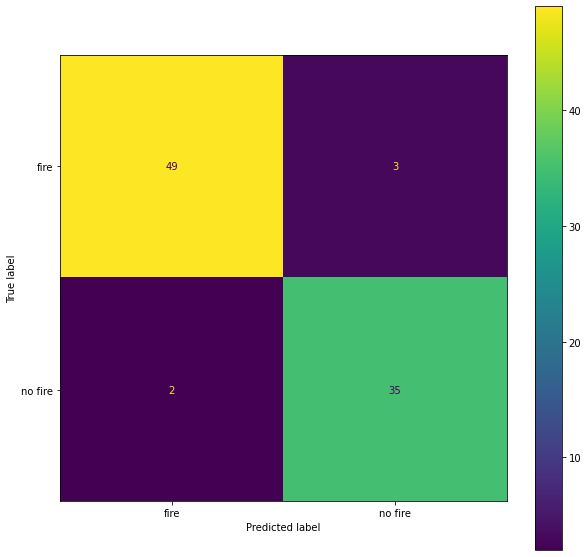

In [81]:
plot_cm (logit, X_test, y_test)

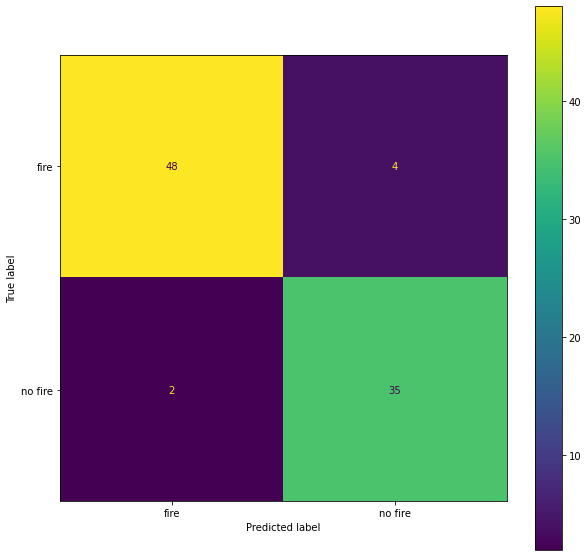

In [82]:
plot_cm (best_log_mod, X_test, y_test)

## 2. Decision Tree

In [83]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train, y_train)

### Hyperparameter Tuning

In [84]:
param_grid = {
    'max_depth': [3, 5, None],
    'min_samples_leaf': [np.random.randint(1, 10)],
    'criterion': ['gini', 'entropy', 'log_loss']
              }

rand_search = GridSearchCV(tree, param_grid, scoring='accuracy', cv=5, verbose=True)

best_tree_mod = rand_search.fit(X_train, y_train)

best_tree_mod.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)

### Performance evaluation

#### Training data

In [85]:
print ('Evaluating the model trained data \n')

# Standard
tree_pred_train_label = tree.predict(X_train)
accuracy = accuracy_score(y_train, tree_pred_train_label)

rmse = np.sqrt(mse)
print(f"Evaluating the Standard Model: accuracy score: {accuracy} \n")

# hyperparameters
tree_pred_train_label = best_tree_mod.predict(X_train)
accuracy = accuracy_score(y_train, tree_pred_train_label)

rmse = np.sqrt(mse)
print(f"Evaluating the Hyperparameter Tuned model: accuracy score: {accuracy}")

Evaluating the model trained data 

Evaluating the Standard Model: 
 RMSE: 0.0 
 accuracy score: 1.0 

Evaluating the Hyperparameter Tuned model: 
 RMSE: 0.26650089544451305 
 accuracy score: 0.9289772727272727


#### Testing data

In [86]:
print ('Evaluating the model with test data \n')

# Standard
tree_pred_test_label = tree.predict(X_test)
accuracy = accuracy_score(y_test, tree_pred_test_label)

rmse = np.sqrt(mse)
print(f"Evaluating the Standard model: accuracy score: {accuracy} \n")

# hyperparameters
tree_pred_test_label = best_tree_mod.predict(X_test)
accuracy = accuracy_score(y_test, tree_pred_test_label)

rmse = np.sqrt(mse)
print(f"Evaluating the Hyperparameter Tuned model: accuracy score: {accuracy} \n")

Evaluating the model with test data 

Evaluating the Standard model: 
 RMSE: 0.317999364001908 
 accuracy score: 0.898876404494382 

Evaluating the Hyperparameter Tuned model: 
 RMSE: 0.2804490780752513 
 accuracy score: 0.9213483146067416 



### Confusion Matrix 

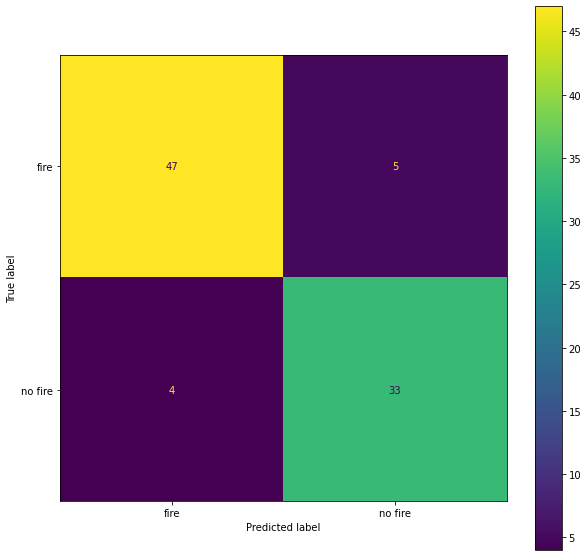

In [87]:
plot_cm (tree, X_test, y_test)

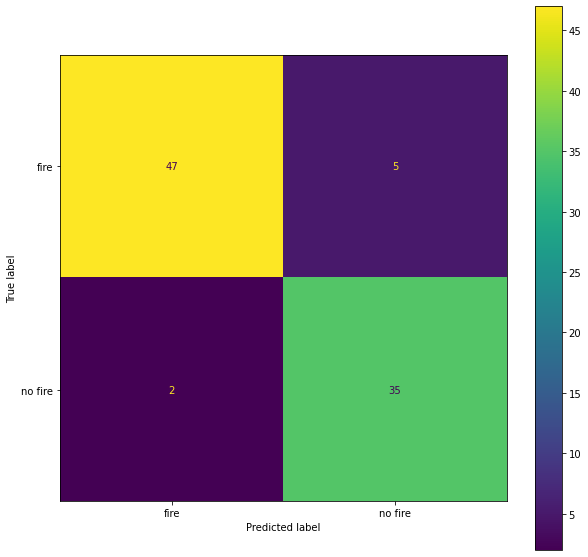

In [88]:
plot_cm (best_tree_mod, X_test, y_test)

## 3. Neural Network

In [89]:
# Standardize the data using a neural network

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [90]:
MLP = MLPClassifier()
MLP.fit(X_train, y_train)

MLPClassifier()

### Hyperparameter Tuning

In [91]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (10, 50, 10), (20,)],
    'activation': ['logistic', 'tanh', 'relu'],
    # 'criterion': ['gini', 'entropy', 'log_loss'],
    # 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'learning_rate_init': [0.001, 0.05],
    'solver': ['sgd', 'adam'],
              }

grid_search = GridSearchCV(MLP, param_grid, cv=5, verbose=True, n_jobs=-1)

best_mlp_mod = grid_search.fit(X_train, y_train)

best_mlp_mod.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


MLPClassifier(hidden_layer_sizes=(20,))

### Performance evaluation

#### Training data

In [92]:
print ('Evaluating the model trained data \n')

# Standard
mlp_pred_train_label = MLP.predict(X_train)
accuracy = accuracy_score(y_train, mlp_pred_train_label)
mse = mean_squared_error(y_train, mlp_pred_train_label)
rmse = np.sqrt(mse)
print(f"Evaluating the Standard Model: accuracy score: {accuracy} \n")

# hyperparameters
mlp_pred_train_label = best_mlp_mod.predict(X_train)
accuracy = accuracy_score(y_train, mlp_pred_train_label)
mse = mean_squared_error(y_train, mlp_pred_train_label)
rmse = np.sqrt(mse)
print(f"Evaluating the Hyperparameter Tuned model: accuracy score: {accuracy}")

Evaluating the model trained data 

Evaluating the Standard Model: 
 RMSE: 0.13055824196677338 
 accuracy score: 0.9829545454545454 

Evaluating the Hyperparameter Tuned model: 
 RMSE: 0.1767766952966369 
 accuracy score: 0.96875


#### Testing data

In [93]:
print ('Evaluating the model with test data \n')

# Standard
mlp_pred_test_label = MLP.predict(X_test)
accuracy = accuracy_score(y_test, mlp_pred_test_label)
mse = mean_squared_error(y_test, mlp_pred_test_label)
rmse = np.sqrt(mse)
print(f"Evaluating the Standard model: accuracy score: {accuracy} \n")

# hyperparameters
mlp_pred_test_label = best_mlp_mod.predict(X_test)
accuracy = accuracy_score(y_test, mlp_pred_test_label)
mse = mean_squared_error(y_test, mlp_pred_test_label)
rmse = np.sqrt(mse)
print(f"Evaluating the Hyperparameter Tuned model: accuracy score: {accuracy} \n")

Evaluating the model with test data 

Evaluating the Standard model: 
 RMSE: 0.2804490780752513 
 accuracy score: 0.9213483146067416 

Evaluating the Hyperparameter Tuned model: 
 RMSE: 0.317999364001908 
 accuracy score: 0.898876404494382 



### Confusion Matrix

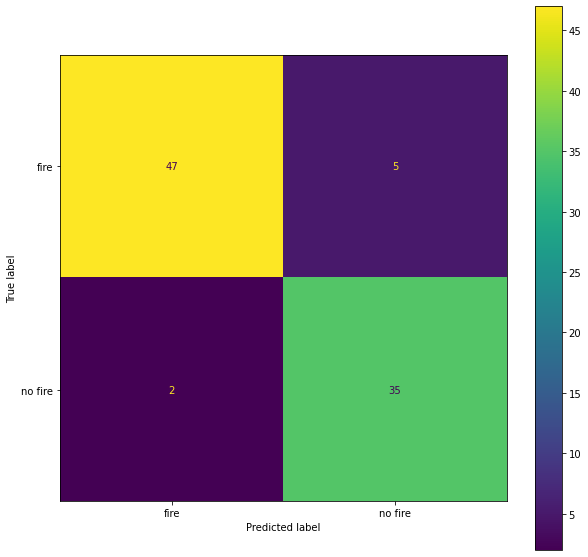

In [94]:
plot_cm (MLP, X_test, y_test)

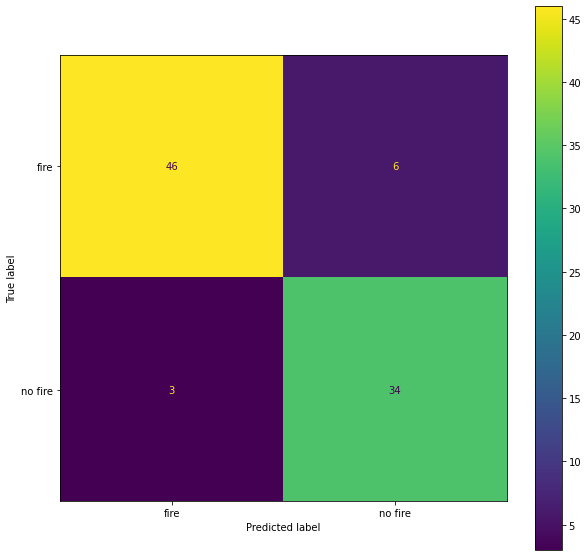

In [95]:
plot_cm (best_mlp_mod, X_test, y_test)